In [1]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

def nan_hook(self, inp, output):
    if not isinstance(output, tuple):
        outputs = [output]
    else:
        outputs = output

    for i, out in enumerate(outputs):
        nan_mask = torch.isnan(out)
        if nan_mask.any():
            print(outputs)
            print("In ", self.__class__.__name__)
            raise RuntimeError(f"Found NAN in output {i}")

c:\Users\Hanse Kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class EvalEig(nn.Module):
    def __init__(self, eval_para):
        super().__init__()
        self.rn = eval_para['r_dsc'] # maintain Delta r
        self.rm = eval_para['r_infty'] # maintain V(infty) ~ 0
        self.ln = eval_para['l_max']+1
        self.para = eval_para

        # l x r
        self.r_dsc = torch.linspace(self.rm/self.rn, self.rm, self.rn)
        self.l_dsc = torch.arange(0,self.ln, dtype = torch.int).view(1,-1,1,1)
        
        self.r_dsc_pw = (torch.linspace(1/self.rn, 1, self.rn).view(-1,1).expand(-1,eval_para['pw']+1)**(torch.cat((torch.tensor([-1]), torch.arange(1, eval_para['pw']+1))))).T
        #self.r_dsc_poly = (self.r_dsc.view(-1,1).expand(-1,eval_para['pw'])**torch.arange(1, eval_para['pw']+1)).T
    
    def dsc_eigs(self, ptl):
        dsc_lap = (-2*torch.eye(self.rn) + torch.diag(torch.ones(self.rn-1),1) + torch.diag(torch.ones(self.rn-1),-1))*(self.rn/self.rm)**2
        dsc_lap = dsc_lap.view(1, 1, self.rn, self.rn)
        dsc_ptl = torch.diag_embed(ptl).view(ptl.shape[0],1,self.rn,self.rn)
        dsc_eff = self.l_dsc*(self.l_dsc+1)*torch.diag(1/self.r_dsc**2).view(1, 1, self.rn,self.rn)
        
        dsc_hmt = (-self.para['para_0']*dsc_lap + dsc_ptl + self.para['para_0']*dsc_eff)

        #print(dsc_hmt)

        evl, _ = torch.linalg.eigh(dsc_hmt)
        # bound state condition
        # evl[evl>0] = torch.tensor(0)

        return evl

class InvEig(EvalEig):
    def __init__(self, clip_size, eval_para, model_para):
        super().__init__(eval_para)
        # model
        modules = seq_mlp(init = clip_size*self.ln, mlp = model_para['mlp'],
                          fin = eval_para['pw'] + 1, act = nn.ReLU())
        self.mlp = nn.Sequential(*modules)


    def forward(self, energy):
        # obtain potential via model
        # via mlp
        coeffs_temp = self.mlp(energy.reshape(energy.shape[0]*energy.shape[1],energy.shape[2]))
        self.coeffs = torch.cat((-torch.abs(coeffs_temp[:,:1]),coeffs_temp[:,1:]),dim=1)
        ptl_md = self.coeffs @ self.r_dsc_pw
        #r_poly = self.coeffs @ self.r_dsc_poly
        #ptl_md = 1/r_poly

        # calculate learned energy
        evl_md = self.dsc_eigs(ptl_md)

        return ptl_md, evl_md

In [13]:
print(torch.__version__)
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.4.1+cu124
12.4
cuda


In [14]:
eval_para = {
        # evaluation model
        'r_infty' : 100, # high r_infty maintains V(infty) ~ 0
        'r_dsc' : 1000, # computation time vs accuracy; maintain delta r ~ 0
        'l_max' : 0, # maximum l_max to evaluate radial schrodinger upto
        
        # potential specifics
        'ptl_form' : 'coulomb',
        'para_0' : 1, # hbar^2/2m
        'para_1' : 1, # scales energy; scales horizontally (r_rat) and modelwise (r_dsc)

        # model specifics
        'precision' : 64, # 32 or 64 bit
        'pw' : 5, # consider 1/r and up to r^n
        'batch_dim' : 400,
        }

model_para = {
        # model
        'mlp' : [100, 100, 100],

        # training
        'epoch' : 100,
        'lr' : 1e-2,

        # loss regularisation
        'reg1' : 1e-1, # smoothness
        
        }

In [15]:
eval = EvalEig(eval_para)

coeffs_tr = torch.rand(eval_para['batch_dim'], eval_para['pw'])*eval_para['para_1']
coeffs_tr[:,0] = -torch.abs(coeffs_tr[:,0])
coeffs_tr[:,1:] = torch.tensor([0])
#coeffs_tr[:,1:] = coeffs_tr[:,1:]*10 - 5

ptl_tr = coeffs_tr @ eval.r_dsc_pw
evl_tr = eval.dsc_eigs(ptl_tr)

TypeError: linspace() received an invalid combination of arguments - got (float, float, float), but expected one of:
 * (Tensor start, Tensor end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Tensor end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Tensor start, Number end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [77]:
clip_size = evl_tr[evl_tr < 0].shape[0] // eval_para['batch_dim']
print(clip_size)

45


In [78]:
model = InvEig(clip_size, eval_para, model_para)

In [79]:
#for submodule in model.modules():
#    submodule.register_forward_hook(nan_hook)
optimiser = torch.optim.Adam(model.parameters(), lr = model_para['lr'])
epochs = model_para['epoch']
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')
loss_list = [[]]

for e in range(epochs):
    #ptl_md, evl_md = model(hp['true'])
    #with torch.autograd.detect_anomaly():
    
    ptl_md, evl_md = model(evl_tr[:,:,:clip_size])
    loss = nn.L1Loss()(evl_tr[:,:,:clip_size], evl_md[:, :,:clip_size])

    if e == 0:
        ptl_init = ptl_md

    loss_list[0].append(loss.item())

    #print(loss_0.item(), loss.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pbar.update()

Progress: 100%|██████████| 100/100 [40:38<00:00, 24.41s/it]

In [80]:
torch.save(model.state_dict(), f"{eval_para['batch_dim']}_{eval_para['pw']}.pth")
#model.load_state_dict(torch.load('.pth'))

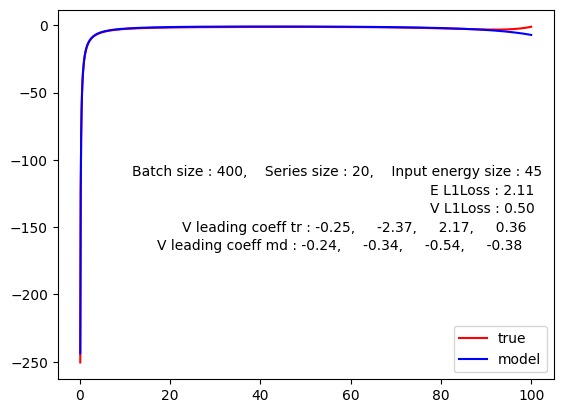

In [86]:
plt.figure()
i = 0
plt.plot(eval.r_dsc, ptl_tr[i], label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md[i].squeeze(0).detach(), label='model', color = 'blue')
plt.legend()
plt.annotate(f"Batch size : {eval_para['batch_dim']},\
    Series size : {eval_para['pw']},\
    Input energy size : {clip_size}", xy = {0.15, 0.55}, xycoords="axes fraction")
plt.annotate(f"E L1Loss : {loss:.2f}", xy = (0.75, 0.5), xycoords="axes fraction")
plt.annotate(f"V L1Loss : {nn.L1Loss()(ptl_tr[i], ptl_md[i]).item():.2f}", xy = (0.75, 0.45), xycoords="axes fraction")
plt.annotate(f"V leading coeff md : {model.coeffs[i,0].item():.2f}, \
    {model.coeffs[i,1].item():.2f}, \
    {model.coeffs[i,2].item():.2f}, \
    {model.coeffs[i,3].item():.2f}", xy = (0.2, 0.35), xycoords="axes fraction")
plt.annotate(f"V leading coeff tr : {coeffs_tr[i,0].item():.2f}, \
    {coeffs_tr[i,1].item():.2f}, \
    {coeffs_tr[i,2].item():.2f}, \
    {coeffs_tr[i,3].item():.2f}", xy = (0.25, 0.4), xycoords="axes fraction")
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_{i}ptl.png")

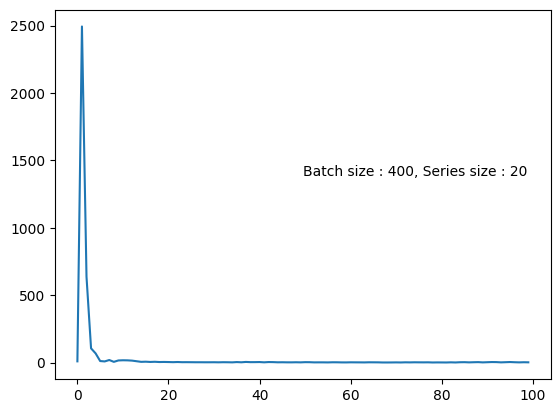

In [87]:
plt.figure()
j = 0
plt.plot(range(epochs-j), loss_list[0][j:])
plt.annotate(f"Batch size : {eval_para['batch_dim']}, Series size : {eval_para['pw']}", xy = {0.5, 0.55}, xycoords="axes fraction")
plt.savefig(f"{eval_para['batch_dim']}_{eval_para['pw']}_loss.png")

In [14]:
print((evl_tr[:,:,:clip_size]-evl_md[:, :,:clip_size])/evl_tr[:,:,:clip_size])
print(evl_tr[:,:,:clip_size])

tensor([[[ 6.2011e-02,  7.2921e-02,  7.9545e-02,  ...,  5.1491e-01,
           5.0970e-01,  5.0511e-01]],

        [[ 4.5910e-02,  5.3622e-02,  5.8968e-02,  ...,  2.4504e+00,
           2.2228e+00,  2.0535e+00]],

        [[ 7.2054e-02,  8.2889e-02,  9.1233e-02,  ...,  2.1990e+00,
           1.9797e+00,  1.8568e+00]],

        ...,

        [[ 6.5227e-02,  7.4985e-02,  8.2594e-02,  ...,  4.1312e+02,
           1.2329e+01,  6.5372e+00]],

        [[ 5.9577e-02,  6.9955e-02,  7.6813e-02,  ...,  3.8517e-01,
           3.8133e-01,  3.9891e-01]],

        [[-1.1634e-02, -1.3052e-02, -1.2522e-02,  ...,  2.7397e-01,
           2.7518e-01,  2.7480e-01]]], grad_fn=<DivBackward0>)
tensor([[[-4.1341e+02, -1.5222e+02, -7.8123e+01,  ...,  2.9877e+00,
           3.1404e+00,  3.2911e+00]],

        [[-5.4798e+02, -2.1214e+02, -1.1258e+02,  ...,  3.9364e-01,
           4.3176e-01,  4.5577e-01]],

        [[-7.3124e+02, -2.9678e+02, -1.6318e+02,  ...,  1.1050e+00,
           1.2675e+00,  1.4261e+00]],


tensor([[[-1.5407e+01, -3.9608e+00, -1.7699e+00, -9.9752e-01, -6.3899e-01,
          -4.4397e-01, -3.2627e-01, -2.4985e-01, -1.9744e-01, -1.5994e-01,
          -1.3219e-01, -1.1108e-01, -9.4493e-02, -7.9633e-02, -6.2797e-02,
          -4.2726e-02, -1.9618e-02,  6.2739e-03,  3.4793e-02,  6.5807e-02,
           9.9250e-02,  1.3506e-01,  1.7318e-01,  2.1357e-01,  2.5621e-01,
           3.0106e-01,  3.4810e-01,  3.9731e-01,  4.4867e-01,  5.0218e-01,
           5.5781e-01,  6.1555e-01,  6.7540e-01,  7.3733e-01,  8.0136e-01,
           8.6746e-01,  9.3562e-01,  1.0058e+00,  1.0781e+00,  1.1525e+00,
           1.2288e+00,  1.3073e+00,  1.3877e+00,  1.4702e+00,  1.5547e+00]]])


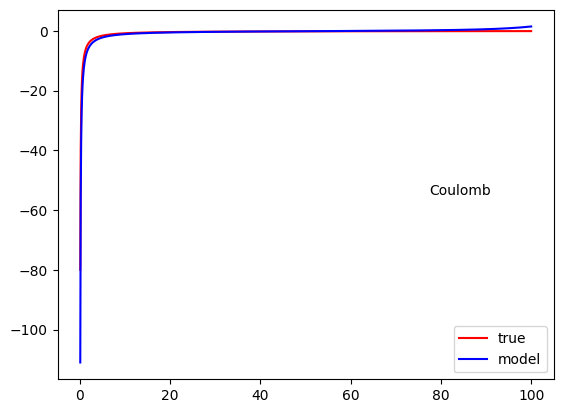

In [88]:
# robustness test
ptl_tr_coulomb = -8/eval.r_dsc

evl_tr_coulomb = eval.dsc_eigs(ptl_tr_coulomb.reshape(1,1,eval.rn))
print(evl_tr_coulomb[:,:,:clip_size])
ptl_md_coulomb, evl_md_coulomb = model(evl_tr_coulomb[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_coulomb, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_coulomb.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Coulomb", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[-8.7492e+00, -9.5852e-02,  1.0572e-03,  4.3050e-03,  9.7181e-03,
           1.7272e-02,  2.6953e-02,  3.8742e-02,  5.2625e-02,  6.8586e-02,
           8.6611e-02,  1.0669e-01,  1.2882e-01,  1.5298e-01,  1.7917e-01,
           2.0738e-01,  2.3762e-01,  2.6987e-01,  3.0414e-01,  3.4042e-01,
           3.7870e-01,  4.1899e-01,  4.6129e-01,  5.0558e-01,  5.5187e-01,
           6.0016e-01,  6.5045e-01,  7.0273e-01,  7.5700e-01,  8.1326e-01,
           8.7152e-01,  9.3176e-01,  9.9399e-01,  1.0582e+00,  1.1244e+00,
           1.1926e+00,  1.2628e+00,  1.3349e+00,  1.4090e+00,  1.4851e+00,
           1.5632e+00,  1.6433e+00,  1.7253e+00,  1.8093e+00,  1.8953e+00]]])


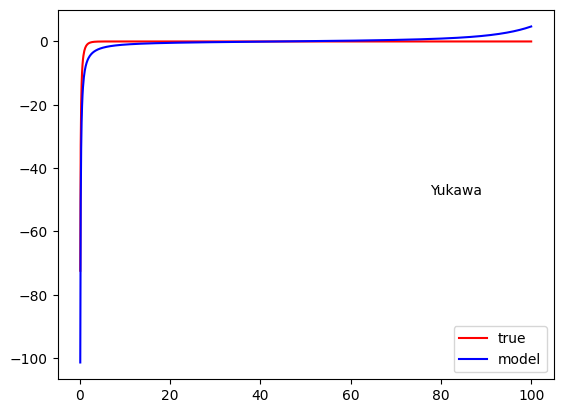

In [89]:
# robustness test
ptl_tr_yukawa = -8*torch.exp(-eval.r_dsc)/eval.r_dsc

evl_tr_yukawa = eval.dsc_eigs(ptl_tr_yukawa.reshape(1,1,eval.rn))
print(evl_tr_yukawa[:,:,:clip_size])
ptl_md_yukawa, evl_md_yukawa = model(evl_tr_yukawa[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_yukawa, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_yukawa.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Yukawa", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[-1.4718e+01, -1.9183e+00, -1.5668e-01, -1.2942e-01, -1.0848e-01,
          -9.1970e-02, -7.6588e-02, -5.8531e-02, -3.6915e-02, -1.2010e-02,
           1.5936e-02,  4.6737e-02,  8.0262e-02,  1.1641e-01,  1.5508e-01,
           1.9622e-01,  2.3974e-01,  2.8559e-01,  3.3372e-01,  3.8407e-01,
           4.3660e-01,  4.9126e-01,  5.4802e-01,  6.0682e-01,  6.6764e-01,
           7.3044e-01,  7.9516e-01,  8.6179e-01,  9.3028e-01,  1.0006e+00,
           1.0727e+00,  1.1465e+00,  1.2221e+00,  1.2993e+00,  1.3263e+00,
           1.3781e+00,  1.4585e+00,  1.5404e+00,  1.6238e+00,  1.7085e+00,
           1.7946e+00,  1.8817e+00,  1.9699e+00,  2.0588e+00,  2.1480e+00]]])


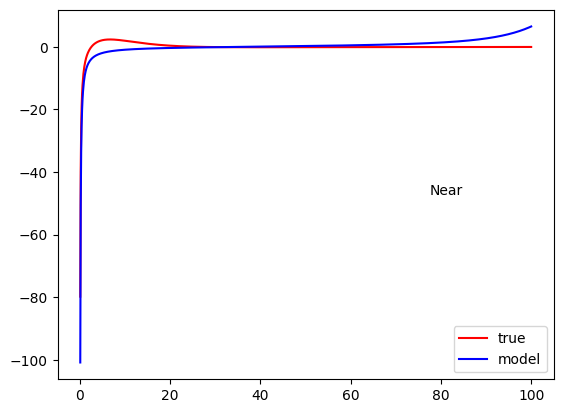

In [90]:
# robustness test
ptl_tr_near = -8/eval.r_dsc + 10*torch.exp(-eval.r_dsc/5)*eval.r_dsc/5

evl_tr_near = eval.dsc_eigs(ptl_tr_near.reshape(1,1,eval.rn))
print(evl_tr_near[:,:,:clip_size])
ptl_md_near, evl_md_near = model(evl_tr_near[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_near, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_near.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Near", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()

tensor([[[-15.8105, -10.5418,  -9.5728,  -8.8190,  -8.1821,  -7.6239,  -7.1240,
           -6.6702,  -6.2544,  -5.8706,  -5.5145,  -5.1827,  -4.8726,  -4.5819,
           -4.3763,  -4.3089,  -4.0520,  -3.8100,  -3.5818,  -3.3664,  -3.1629,
           -2.9707,  -2.7891,  -2.6174,  -2.4552,  -2.3021,  -2.2062,  -2.1575,
           -2.0212,  -1.8928,  -1.7720,  -1.6586,  -1.5524,  -1.4663,  -1.4534,
           -1.3615,  -1.2768,  -1.1999,  -1.1595,  -1.1322,  -1.0789,  -1.0417,
           -0.9965,  -0.9432,  -0.8851]]])


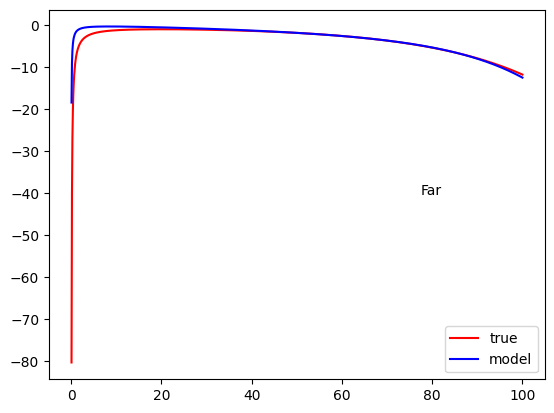

In [91]:
# robustness test
ptl_tr_far = -8/eval.r_dsc*torch.exp(eval.r_dsc/20)

evl_tr_far = eval.dsc_eigs(ptl_tr_far.reshape(1,1,eval.rn))
print(evl_tr_far[:,:,:clip_size])
ptl_md_far, evl_md_far = model(evl_tr_far[:,:,:clip_size])

plt.plot(eval.r_dsc, ptl_tr_far, label='true', color = 'red')
#plt.plot(eval.r_dsc, ptl_init[i].squeeze(0).detach(), label='model_i', color = 'green')
plt.plot(eval.r_dsc, ptl_md_far.squeeze(0).detach(), label='model', color = 'blue')
plt.annotate(f"Far", xy = (0.75, 0.5), xycoords="axes fraction")
plt.legend()